In [1]:
! pip install livelossplot

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached bokeh-3.1.0-py3-none-any.whl (8.3 MB)
  Using cached contourpy-1.0.7-cp311-cp311-win_amd64.whl (162 kB)
     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/10.3 MB 1.4 MB/s eta 0:00:08
     - -------------------------------------- 0.3/10.3 MB 2.6 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/10.3 MB 3.3 MB/s eta 0:00:03
     --- ------------------------------------ 0.9/10.3 MB 4.3 MB/s eta 0:00:03
     ----- ---------------------------------- 1.3/10.3 MB 4.9 MB/s eta 0:00:02
     ------ --------------------------------- 1.6/10.3 MB 5.2 MB/s eta 0:00:02
     ------- -------------------------------- 2.1/10.3 MB 5.7 MB/s eta 0:00:02
     --------- ------------------------------ 2.5/10.3 MB 

In [2]:
! pip3 install --upgrade tensorflow

In [31]:
! pip install tensorflow==2.1.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.1.0

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from livelossplot import PlotLossesKeras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isdir, isfile, join

In [5]:
data_dir = r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset'

img_width = 300
img_height = 300

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [6]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.3,
    width_shift_range=0.3,
    brightness_range=[0.1,0.9],
    rotation_range=90,
    validation_split=0.1,
    zoom_range=0.1
)

In [7]:
CLASSES = sorted(listdir(data_dir))
CLASSES

['Ak',
 'Ala_Idris',
 'Buzgulu',
 'Dimnit',
 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt',
 'Nazli']

In [8]:
train_gen = datagen.flow_from_directory(
    data_dir, 
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True,
    seed=242
)

validation_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='validation',
    shuffle=True,
    seed=116,
)

Found 450 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [9]:
def plot_images(path, datagen):
    
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Data')
    
    index = 0
    for location in path:
        img = Image.open(location)
        img = img.resize((242,242))
        samples = np.expand_dims(img, 0)
        it = datagen.flow(samples, batch_size=1)
        
        # Show Original Image
        plt.subplot(10,5, index+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            index += 1
            plt.subplot(10,5, index+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        index += 1
        
    plt.tight_layout()
    plt.show()

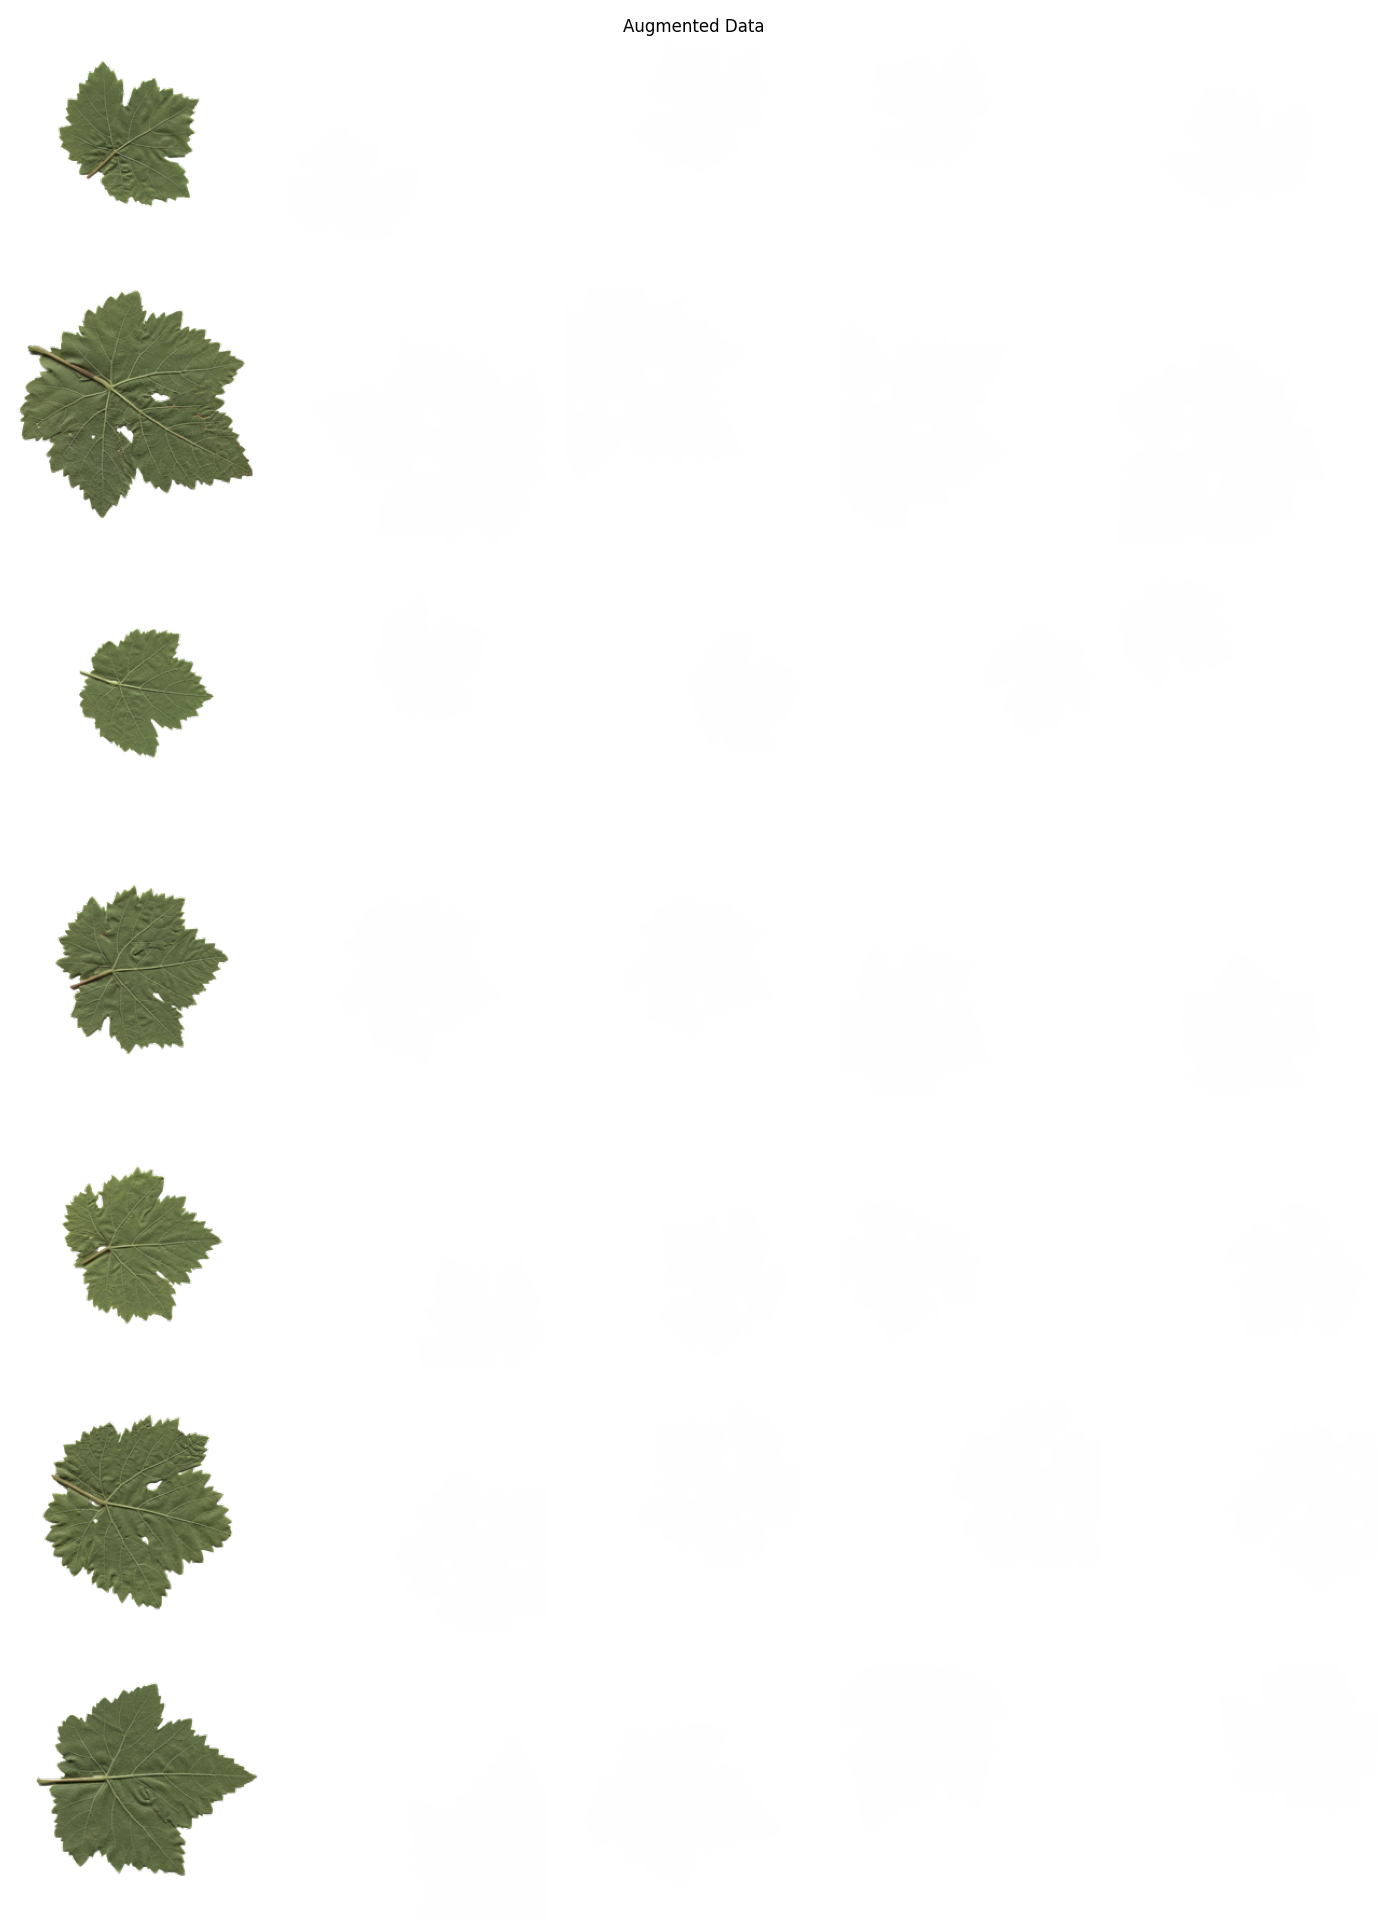

In [10]:
plot_images([
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (6).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (26).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (12).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (31).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (8).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (17).png',
    r'C:\Users\harsh\Downloads\project2\project2\Grapevine_Leaves_Image_Dataset\Ak\Ak (22).png'
], datagen)

In [11]:
inception_model = Sequential()

# base_model
inception_base_model = InceptionV3(include_top=False,input_shape=(img_width, img_height,3))
inception_base_model.trainable=False

inception_model.add(inception_base_model)

#### Fully-Connected Layer ####
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dropout(0.15))
inception_model.add(Dense(1024, activation='relu'))
inception_model.add(Dense(len(CLASSES), activation='softmax'))

inception_model.summary()

87910968/87910968 [==============================] - 11s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,907,110
Trainable params: 2,104,326
Non

In [12]:
vgg16_model = Sequential()

# base_model
vgg16_base_model = VGG16(include_top=False,input_shape=(img_width, img_height,3))
vgg16_base_model.trainable=False

vgg16_model.add(vgg16_base_model)

#### Fully-Connected Layer ####
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(Dropout(0.15))
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(len(CLASSES), activation='softmax'))

vgg16_model.summary()

58889256/58889256 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 15,246,150
Trainable params: 531,462
Non-

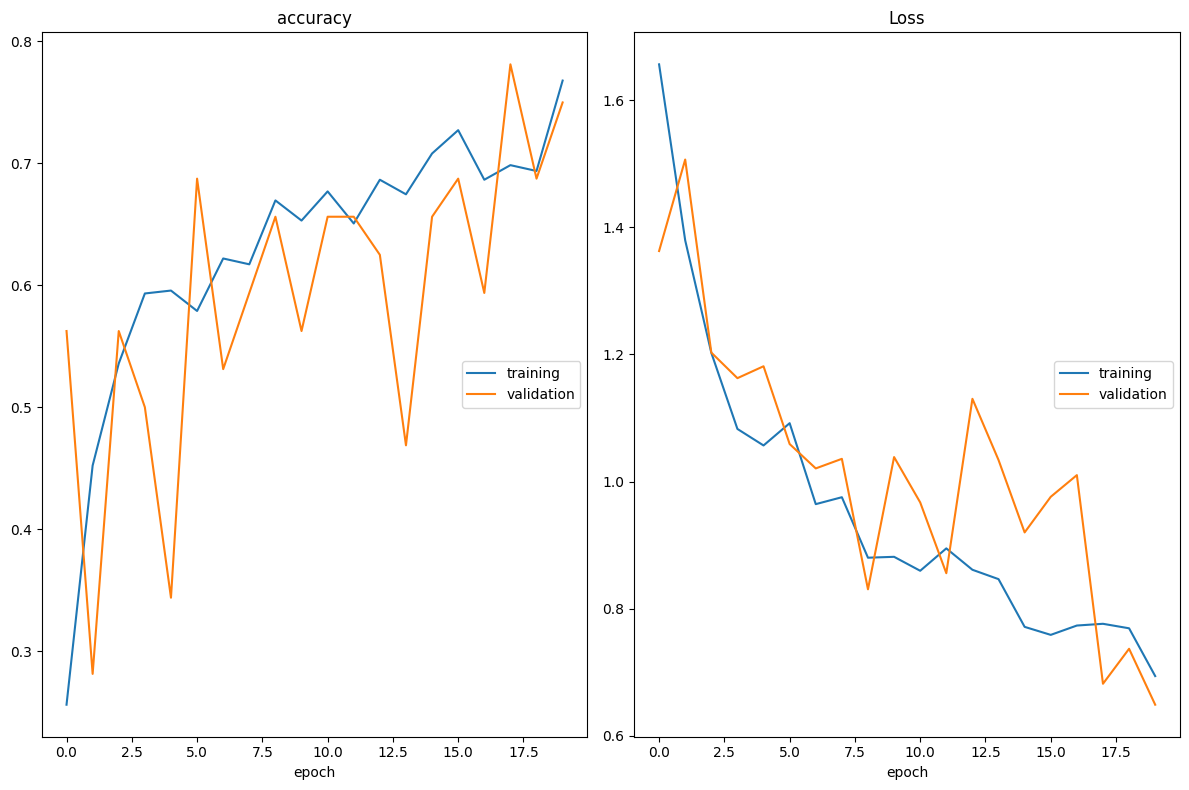

accuracy
	training         	 (min:    0.256, max:    0.768, cur:    0.768)
	validation       	 (min:    0.281, max:    0.781, cur:    0.750)
Loss
	training         	 (min:    0.694, max:    1.656, cur:    0.694)
	validation       	 (min:    0.649, max:    1.506, cur:    0.649)
14/14 [==============================] - 48s 3s/step - loss: 0.6941 - accuracy: 0.7679 - val_loss: 0.6491 - val_accuracy: 0.7500


In [13]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = Adam(learning_rate=0.0001)

inception_model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = inception_model.fit(
    train_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)

In [14]:
test_loss, test_acc = inception_model.evaluate(validation_gen)
print('test accuracy : ', test_acc)


trained_model = load_model('img_model.trained.weights.hdf5')

2/2 [==============================] - 4s 1s/step - loss: 0.7827 - accuracy: 0.7000
test accuracy :  0.699999988079071


In [15]:
trained_model.save('model.h5')

In [ ]:
# steps_for_each_epoch = train_gen.samples // BATCH_SIZE
# validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

# OPTIMIZER = Adam(learning_rate=0.0001)

# vgg16_model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

# ## save model after every epoch ##
# checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

# ## Early stopping to stop over training
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# history = vgg16_model.fit(
#     train_gen, 
#     epochs=EPOCHS, 
#     steps_per_epoch=steps_for_each_epoch,
#     validation_data=validation_gen,
#     validation_steps=validation_steps_for_each_epoch,
#     callbacks=[early_stop, checkpointer, PlotLossesKeras()],
#     verbose=True
# )



In [ ]:
#test_loss, test_acc = vgg16_model.evaluate(validation_gen)
#print('test accuracy : ', test_acc)

In [15]:
! pip3 install flask


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
